# Process dataset for use with deep learning segmentation network
> A guide for processing raster data and labels into ML-ready format for use with a deep-learning based semantic segmentation.

## Setup Notebook

```{admonition} **Version control**
Colab updates without warning to users, which can cause notebooks to break. Therefore, we are pinning library versions.
``` 

In [1]:
# install required libraries
!pip install -q rasterio==1.2.10
!pip install -q geopandas==0.10.2

     |████████████████████████████████| 19.3 MB 1.4 MB/s 
     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 15.4 MB 37.2 MB/s 
     |████████████████████████████████| 6.3 MB 10.6 MB/s 


In [20]:
# import required libraries
import os, glob, functools, fnmatch, json, requests
from zipfile import ZipFile
from itertools import product
import urllib.request

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

import rasterio
from rasterio.merge import merge
from rasterio.plot import show
from rasterio import features, mask, windows

import geopandas as gpd

from IPython.display import clear_output

import cv2

from timeit import default_timer as timer
from tqdm.notebook import tqdm

In [3]:
# Mount google drive.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#### Enabling GPU
```{Tip}
This notebook can utilize a GPU and works better if you use one. Hopefully this notebook is using a GPU, and we can check with the following code.

If it's not using a GPU you can change your session/notebook to use a GPU. See [Instructions](https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=sXnDmXR7RDr2).
```

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

#### Set your root directory, and project level directories.

In [4]:
root_dir = '/content/gdrive/My Drive/servir-tf-devseed/' 
terrabio_dir = root_dir+'terrabio'
rami_dir = root_dir+'rami'

In [5]:
dirs = [terrabio_dir, rami_dir]

In [6]:
for dir in dirs:
  if not os.path.exists(dir):
    os.makedirs(dir)

In [7]:
%cd $root_dir 

/content/gdrive/MyDrive/servir-tf/data/servir-tf-devseed


## Raster processing


<div class="alert alert-block alert-danger">
&#9888 <b>WARNING</b> &#9888 This section contains helper functions for processing the raw raster composites and is <b>optional yet not recommended</b>, as the ML-ready tiled dataset is written to a shared drive folder, as you’ll see in the section titled <b>Read the data into memory</b>.
</div>

Get the optical, spectral index and label mask images. 

 ```python
def raster_read(raster_dir):
    print(raster_dir)
    rasters = glob.glob(raster_dir+'/**/*.vrt',recursive=True)
    print(rasters)

    # Read band metadata and arrays
    # metadata
    rgb = rasterio.open(glob.glob(raster_dir+'/*rgb.tif*')[0]) #rgb
    rgbn = rasterio.open(glob.glob(raster_dir+'/*rgbn.tif*')[0]) #rgbn
    indices = rasterio.open(glob.glob(raster_dir+'/*indices.tif*')[0]) #spectral
    labels = rasterio.open(glob.glob(raster_dir+'/*label.tif*')[0]) #labels
    rgb_src = rgb
    labels_src = labels
    target_crs = rgb_src.crs
    print("rgb: ", rgb)

    # arrays
    # Read and re-scale the original 16 bit image to 8 bit.
    rgb = cv2.normalize(rgb.read(), None, 0, 255, cv2.NORM_MINMAX)
    rgbn = cv2.normalize(rgbn.read(), None, 0, 255, cv2.NORM_MINMAX)
    indices = cv2.normalize(indices.read(), None, 0, 255, cv2.NORM_MINMAX)
    labels = labels.read()
    # Check the label mask values.
    print("values in labels array: ", np.unique(labels))
    return raster_dir, rgb, rgbn, indices, labels, rgb_src, labels_src, target_crs
```

Color correction for the optical composite.
```python
# function to increase the brightness in an image
def change_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v,value)
    v[v > 255] = 255
    v[v < 0] = 0
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img
```

Calculate relevant spectral indices

**WDRVI**: Wide Dynamic Range Vegetation Index \
**NPCRI**: Normalized Pigment Chlorophyll Ratio Index \
**SI**: Shadow Index

```python
# calculate spectral indices and concatenate them into one 3 channel image
def indexnormstack(red, green, blue, nir):
    
    def WDRVIcalc(nir, red): 
        a = 0.15
        wdrvi =  (a * nir-red)/(a * nir+red)
        return wdrvi
    
    def NPCRIcalc(red,blue):
        npcri =  (red-blue)/(red+blue)
        return npcri
    
    def SIcalc(red, green, blue):
        si = ((1-red)*(1-green)*(1-blue))^(1/3)
        return si
    
    def norm(arr):
        arr_norm = (255*(arr - np.min(arr))/np.ptp(arr)) 
        return arr_norm
    
    wdrvi = WDRVIcalc(nir,red) 

    npcri = WRDVIcalc(red,blue)
    
    si = SIcalc(red,green,blue) 
    
    wdrvi = wdrvi.transpose(1,2,0)
    npcri = npcri.transpose(1,2,0)
    si = si.transpose(1,2,0)

    index_stack = np.dstack((wdrvi, npcri, si))
    
    return index_stack
```

If you are rasterizing the labels from a vector file (e.g. GeoJSON or Shapefile)

Read label shapefile into geopandas dataframe, check for invalid geometries and set to local CRS. Then, rasterize the labeled polygons using the metadata from one of the grayscale band images.

```python
def label(geo, labels_src):
    geo = gpd.read_file(geo)
    # check for and remove invalid geometries
    geo = geo.loc[geo.is_valid] 
    # reproject training data into local coordinate reference system
    geo = geo.to_crs(crs={'init': target_crs})
    #convert the class identifier column to type integer
    geo['landcover_int']  = geo.landcover.astype(int)
    # pair the geometries and their integer class values
    shapes = ((geom,value) for geom, value in zip(geo.geometry, geo.landcover_int)) 
    # get the metadata (height, width, channels, transform, CRS) to use in constructing the labeled image array
    labels_src_prf = labels_src.profile
    # construct a blank array from the metadata and burn the labels in
    labels = features.rasterize(shapes=shapes, out_shape=(labels_src_prf['height'], labels_src_prf['width']), fill=0, all_touched=True, transform=labels_src_prf['transform'], dtype=labels_src_prf['dtype'])
    print("Values in labeled image: ", np.unique(labels))
    return labels
```

Write the processed rasters to file

```python
def save_images(raster_dir, rgb_norm, index_stack, labels, rgb_src, labels_src):

    rgb_norm_out=rasterio.open(raster_dir+'/rgb_byte_scaled.tiff', 'w', driver='Gtiff',
                              width=rgb_src.width, height=rgb_src.height,
                              count=3,
                              crs=rgb_src.crs,
                              transform=rgb_src.transform,
                              dtype='uint8')

    rgb_norm_out.write(rgb_norm)
    rgb_norm_out.close()

    indices_computed = False # change to True if using the index helper function above
    if indices_computed:
      index_stack = (index_stack * 255).astype(np.uint8)
      index_stack_t = index_stack.transpose(2,0,1)
    else:
      index_stack_t = index_stack

    index_stack_out=rasterio.open(raster_dir+'/index_stack.tiff', 'w', driver='Gtiff',
                              width=rgb_src.width, height=rgb_src.height,
                              count=3,
                              crs=rgb_src.crs,
                              transform=rgb_src.transform,
                              dtype='uint8')

    index_stack_out.write(index_stack_t)
    index_stack_out.close()
    
    labels = labels.astype(np.uint8)
    labels_out=rasterio.open(raster_dir+'/labels.tiff', 'w', driver='Gtiff',
                              width=labels_src.width, height=labels_src.height,
                              count=1,
                              crs=labels_src.crs,
                              transform=labels_src.transform,
                              dtype='uint8')

    labels_out.write(labels, 1)
    labels_out.close()
    
    return raster_dir+'/index_stack.tiff', raster_dir+'/labels.tiff'
  ```

Now let's divide the optical/index stack and labeled image into 224x224 pixel tiles

```python
def tile(index_stack, labels, prefix, width, height, output_dir, brighten=False):
    tiles_dir = output_dir+'tiled/'
    img_dir = output_dir+'tiled/indices/'
    label_dir = output_dir+'tiled/labels/'
    dirs = [tiles_dir, img_dir, label_dir]
    for d in dirs:
        if not os.path.exists(d):
            os.makedirs(d)
    
    def get_tiles(ds):
        # get number of rows and columns (pixels) in the entire input image
        nols, nrows = ds.meta['width'], ds.meta['height']
        # get the grid from which tiles will be made 
        offsets = product(range(0, nols, width), range(0, nrows, height))
        # get the window of the entire input image
        big_window = windows.Window(col_off=0, row_off=0, width=nols, height=nrows)
        # tile the big window by mini-windows per grid cell
        for col_off, row_off in offsets:
            window = windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
            transform = windows.transform(window, ds.transform)
            yield window, transform
      
    tile_width, tile_height = width, height
    
    def crop(inpath, outpath, c):
        # read input image
        image = rasterio.open(inpath)
        # get the metadata 
        meta = image.meta.copy()
        print("meta: ", meta)
        # set the number of channels to 3 or 1, depending on if its the index image or labels image
        meta['count'] = int(c)
        # set the tile output file format to PNG (saves spatial metadata unlike JPG)
        meta['driver']='PNG'
        meta['dtype']='uint8'
        # tile the input image by the mini-windows
        i = 0
        for window, transform in get_tiles(image):
            meta['transform'] = transform
            meta['width'], meta['height'] = window.width, window.height
            outfile = outpath+"tile_%s_%s.png" % (prefix, str(i))
            with rasterio.open(outfile, 'w', **meta) as outds:
                if brighten:
                  imw = image.read(window=window)
                  imw = imw.transpose(1,2,0)
                  imwb = change_brightness(imw, value=50)
                  imwb = imwb.transpose(2,0,1)
                  outds.write(imwb)
                else:
                  outds.write(image.read(window=window))
            i = i+1
            
    def process_tiles(index_flag):
        # tile the input images, when index_flag == True, we are tiling the spectral index image, 
        # when False we are tiling the labels image
        if index_flag==True:
            inpath = glob.glob(raster_dir+'/*indices_byte_scaled.tiff')[0]
            outpath=img_dir
            crop(inpath, outpath, 3)
        else:
            inpath = glob.glob(raster_dir+'/*label.tif')[0]
            outpath=label_dir
            crop(inpath, outpath, 1)
                
    process_tiles(index_flag=True) # tile index stack
    process_tiles(index_flag=False) # tile labels
    return tiles_dir, img_dir, label_dir
```

Run the image processing workflow

<div class="alert alert-block alert-warning">
&#9888 <b>Pain point</b> &#9888 The reason for not running this raster processing code in this workshop is due to a limitation of a Google Drive based workflow. Having a VM with a mounted SSD would be a good start to solving these associated latency problems incurred from I/O of data hosted in Google Drive.
</div>

```python
process = False
if process:
  raster_dir = terrabio_dir+'/rasters/'

  # If you want to write the files out to your personal drive, set write_out = True, but I recommend trying 
  # that in your free time because it takes about 1 hour for all composites.

  write_out = True #False
  if write_out == True:
      # read the rasters and scale to 8bit
      print("reading and scaling rasters...")
      raster_dir, rgb, rgbn, indices, labels, rgb_src, labels_src, target_crs = raster_read(raster_dir)

      # Calculate indices and combine the indices into one single 3 channel image
      print("calculating spectral indices...")
      index_stack = indexnormstack(rgbn.read(0), rgbn.read(3))

      # Rasterize labels
      #labels = label(root_dir+'train/train.shp', labels_src)

      # Save index stack and labels to geotiff
      print("writing scaled rasters and labels to file...")
      index_stack_file, labels_file = save_images(personal_dir, rgb, index_stack, labels, rgb_src, labels_src)

      # Tile images into 224x224
      print("tiling the indices and labels...")
      tiles_dir, img_dir, label_dir = tile(index_stack, labels, 'terrabio', 224, 224, terrabio_gcs_to_local_dir, brighten=False)
  else:
    print("Not writing to file; using data in shared drive.")

else:
  print("Using pre-processed dataset.")
```

## Read the data into memory

#### Getting set up with the data

```{important}
Create drive shortcuts of the tiled imagery to your own My Drive Folder by Right-Clicking on the Shared folder `servir-tf-devseed`. Then, this folder will be available at the following path that is accessible with the google.colab `drive` module: `'/content/gdrive/My Drive/servir-tf-devseed/'`
```

We'll be working witht he following folders in the `servir-tf-devseed` folder:
```
servir-tf-devseed/
├── images/
├── images_bright/
├── indices/
├── indices_800/
├── labels/
├── labels_800/
├── background_list_train.txt
└── terrabio_classes.csv
```

Let's confirm the contents of the current directory.

In [9]:
!ls

background_list_train.txt  images_bright  labels      terrabio
Blocks			   indices	  labels_800  terrabio_classes.csv
images			   indices_800	  rami


In [10]:
# set the paths to point to the tiles images
img_dir = './indices/'
label_dir = './labels/'

In [11]:
# get initial counts of train images
%ls $img_dir | wc -l
%ls $label_dir | wc -l

74700
74700


In [12]:
# get lists of image and label tile pairs for training

def get_train_test_lists(imdir, lbldir):
  imgs = glob.glob(imdir+"/*.png")
  dset_list = []
  for img in imgs:
    filename_split = os.path.splitext(img) 
    filename_zero, fileext = filename_split 
    basename = os.path.basename(filename_zero) 
    dset_list.append(basename)
    
  x_filenames = []
  y_filenames = []
  for img_id in dset_list:
    x_filenames.append(os.path.join(imdir, "{}.png".format(img_id)))
    y_filenames.append(os.path.join(lbldir, "{}.png".format(img_id)))
    
  print("number of images: ", len(dset_list))
  return dset_list, x_filenames, y_filenames

In [13]:
train_list, x_train_filenames, y_train_filenames = get_train_test_lists(img_dir, label_dir)

number of images:  37350


Let's check for the proportion of background tiles. This takes a while. So we can skip by loading from saved results.

In [30]:
skip = True

if not skip:
  background_list_train = []
  for i in train_list: 
      # read in each labeled images
      # print(label_dir+"{}.png".format(i))
      img = np.array(Image.open(label_dir+"{}.png".format(i))) 
      # check if no values in image are greater than zero (background value)
      if img.max()==0:
          background_list_train.append(i)
          
  print("Number of background images: ", len(background_list_train))

  with open(os.path.join(personal_dir,'background_list_train.txt'), 'w') as f:
    for item in background_list_train:
        f.write("%s\n" % item)

else:
  background_list_train = [line.strip() for line in open("background_list_train.txt", 'r')]
  print("Number of background images: ", len(background_list_train))

Number of background images:  36489


We will keep only 10% of the total. Too many background tiles can cause a form of class imbalance.

In [31]:
background_removal = len(background_list_train) * 0.9
train_list_clean = [y for y in train_list if y not in background_list_train[0:int(background_removal)]]

x_train_filenames = []
y_train_filenames = []
for img_id in train_list_clean: 
  x_train_filenames.append(os.path.join(img_dir, "{}.png".format(img_id)))
  y_train_filenames.append(os.path.join(label_dir, "{}.png".format(img_id)))

print("Number of background images: ", background_removal)
print("Remaining number of images after 90% background removal: ", len(train_list_clean))

Number of background images:  32840.1
Remaining number of images after 90% background removal:  4510


Now that we have our set of files we want to use for developing our model, we need to split them into three sets: 
* the training set for the model to learn from
* the validation set that allows us to evaluate models and make decisions to change models
* and the test set that we will use to communicate the results of the best performing model (as determined by the validation set)

We will split index tiles and label tiles into train, validation and test sets: 70%, 20% and 10%, respectively.


In [32]:
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = train_test_split(x_train_filenames, y_train_filenames, test_size=0.3, random_state=42)
x_val_filenames, x_test_filenames, y_val_filenames, y_test_filenames = train_test_split(x_val_filenames, y_val_filenames, test_size=0.33, random_state=42)

num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 3157
Number of validation examples: 906
Number of test examples: 447


```{warning} **Long running cell** \
The code below checks for values in train, val, and test partitions. We won't run this since it takes over 10 minutes on colab due to slow IO.
``` 

```python
vals_train = []
vals_val = []
vals_test = []

def get_vals_in_partition(partition_list, x_filenames, y_filenames):
  for x,y,i in zip(x_filenames, y_filenames, tqdm(range(len(y_filenames)))):
      pass 
      try:
        img = np.array(Image.open(y)) 
        vals = np.unique(img)
        partition_list.append(vals)
      except:
        continue

def flatten(partition_list):
    return [item for sublist in partition_list for item in sublist]

get_vals_in_partition(vals_train, x_train_filenames, y_train_filenames)
get_vals_in_partition(vals_val, x_val_filenames, y_val_filenames)
get_vals_in_partition(vals_test, x_test_filenames, y_test_filenames)
```


``` python
print("Values in training partition: ", set(flatten(vals_train)))
print("Values in validation partition: ", set(flatten(vals_val)))
print("Values in test partition: ", set(flatten(vals_test)))
```
Values in training partition:  {0, 1, 2, 3, 4, 5, 6, 7, 8}

Values in validation partition:  {0, 1, 2, 3, 4, 5, 6, 7, 8}

Values in test partition:  {0, 1, 2, 3, 4, 5, 6, 7, 8}

### Visualize the data

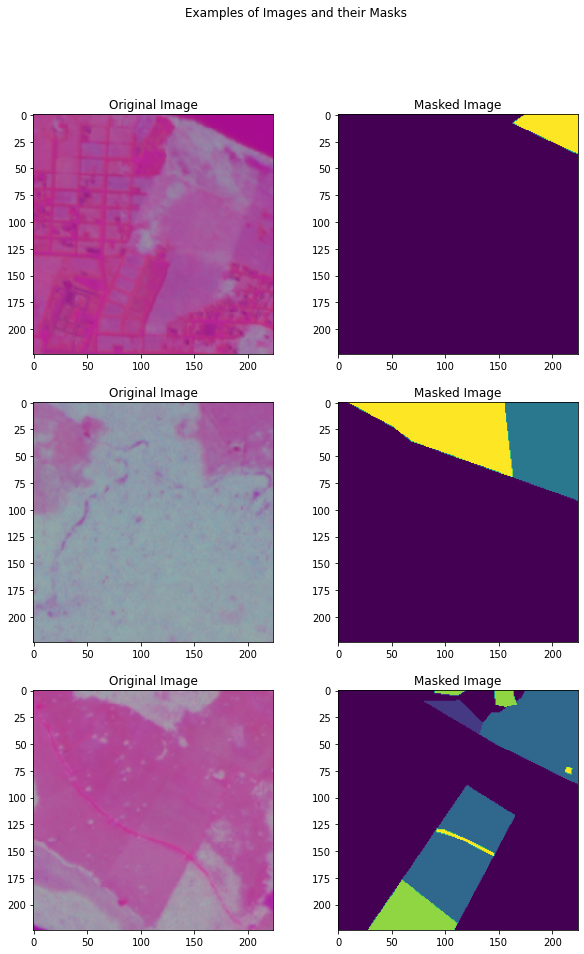

In [38]:
display_num = 3

# select only for tiles with foreground labels present
foreground_list_x = []
foreground_list_y = []
for x,y in zip(x_train_filenames, y_train_filenames): 
    try:
      img = np.array(Image.open(y)) 
      if img.max()>0:
          foreground_list_x.append(x)
          foreground_list_y.append(y)
    except:
      continue

num_foreground_examples = len(foreground_list_y)

# randomlize the choice of image and label pairs
r_choices = np.random.choice(num_foreground_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]
  x_pathname = foreground_list_x[img_num]
  y_pathname = foreground_list_y[img_num]
  
  plt.subplot(display_num, 2, i + 1)
  plt.imshow(mpimg.imread(x_pathname))
  plt.title("Original Image")
  
  example_labels = Image.open(y_pathname)
  label_vals = np.unique(np.array(example_labels))
  
  plt.subplot(display_num, 2, i + 2)
  plt.imshow(example_labels)
  plt.title("Masked Image")  
  
plt.suptitle("Examples of Images and their Masks")
plt.show()